In [9]:
%pylab notebook

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from copy import deepcopy
import secrets
import os

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools
from primo.models.cas9_keras import log_multisite_predictor

# Enable memory growth so that we only use as much GPU memory as needed.
# By default, tensorflow will reserve nearly all of the GPU memory.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=5*10**4
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# To see how this value was derived, please consult the Materials and Methods subsection under 
# Feature Extraction section in Bee et. al. 2021. 
similarity_threshold = 75
# Intuitively determined:
batch_size = 20
val_batch_size = 150

def keras_batch_generator(dataset_batch_generator):
    # Yield datasets
    # Each sample is a triplet with known similar and dissimilar images, so the y_true
    # value is unused in the loss function.
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by
        #   enumerating all the images in the dataset (before splitting them into 
        #   test/train/validate datasets)
        # triplets: A set of three image feature vectos containing anchor, positive (similar) 
        #   image, and negative (dissimilar) image
        indices, triplets = next(dataset_batch_generator)
        yield triplets, np.zeros(len(triplets))

train_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        train_dataset.random_features(batch_size),
        similarity_threshold
    )
)

val_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        validation_dataset.random_features(val_batch_size),
        similarity_threshold
    )
)

train_inputs, train_targets = next(train_batch_generator)

switching to train_f.h5 and train_4.h5


In [11]:
# The reason the default encoder input is a 4096-dimensional vector is
# because we're representing our images through an embedding that was learned
# by a computer vision model known as VGG [1]. We're borrowing the output of the
# 2nd fully-connected layer (i.e. the FC2), which spits out a 4096-by-1 vector.
#
# If you're very curious about VGG's innerworkings, you can see an example tensorflow
# implementation here [2, 3].
#
# Note for future users: If you ever decide to use a different model VGG16,
# you'd probably want to change the input dimension here.
#
# [1] - https://neurohive.io/en/popular-networks/vgg16/
# [2] - https://www.cs.toronto.edu/~frossard/post/vgg16/
# [3] - https://github.com/kentsommer/VGG16-Image-Retrieval/blob/master/vgg16_example.py#L237
INPUT_FEATURE_SIZE = 4096 

# Each CAS site is 20nt, so the output length should be 20nt for single
# site, and a multiple of 20nt for multiple sites.
OUTPUT_LEN = 20

# Temperature used for softmax calculation
SOFTMAX_TEMP = 1.0

# Optionally, load a previously saved model to continue training
MODEL_FILE=None

def hardmax(temperature):
    def hardmax_f(x):
        y = tf.nn.softmax(x / temperature)
        y_hard = tf.one_hot(tf.argmax(y, -1), 4)
        y = tf.stop_gradient(y_hard - y) + y
        return y
    return hardmax_f

# Create the keras model for a single encoder.
encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Lambda(hardmax(SOFTMAX_TEMP)),
], name='encoder')

# Start with previously trained model if a filename is provided
if MODEL_FILE is not None:
    encoder = tf.keras.models.load_model(MODEL_FILE)

# First input is anchor, second is a positive sample, third is a negative sample
X_triplets = layers.Input([3, INPUT_FEATURE_SIZE])

# Essentially, we started with a batch of feature-vector triplets...
# ...And turned them into a triplet of feature-vector batches.
X1, X2, X3 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:], X[:,2,:]))(X_triplets)

# Layer to compute euclidean distances between the triplet pairs for convenience
distances = layers.Lambda(lambda Xs:
                          (
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)),
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[2]), axis=1))
                          ))([X1,X2,X3])

# Independently transforms the batches of feature vectors into one-hot encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)
S3 = encoder(X3)

# Glue them back together! Back into a batch of feature vector triplets.
S_triplets = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2,S3])

# Dimensions: (batch_size x 80 x 4 x 3 ) (i.e. batch size x DNA length x # of nucleotides x 3)
# Swaps dimensions for the loss function, which wants (batch-size x 3 x DNA length x 4)
S_triplets_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_triplets)

encoder_trainer = tf.keras.Model(inputs=X_triplets, outputs=S_triplets_T)

In [12]:
# Defined the loss function, and metrics used for training

def UniquenessMetric(y_true, y_pred):
    seqs = encoder_trainer(train_inputs)
    # Reduce seqs to a single base (e.g. [0.3, 0.1, 0.5, 0.1] -> [2])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def RecallMetric(y_true, y_pred):
    Yp = log_multisite_predictor(tf.gather(y_pred, [0, 1], axis=1))
    return tf.reduce_mean(tf.cast(Yp > -2.0, tf.float32))

def NegRecallMetric(y_true, y_pred):
    Yn = log_multisite_predictor(tf.gather(y_pred, [0, 2], axis=1))
    return tf.reduce_mean(tf.cast(Yn > -2.0, tf.float32))

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

class TripletLoss(object):

    def __call__(self, y_true, y_pred):
        """
        y_pred is triplets of (anchor, positive, negative), with dimensions
        batch_size x 3 x 20 x 4
        """
        pos_distance = -log_multisite_predictor(tf.gather(y_pred, [0,1], axis=1))
        neg_distance = log_multisite_predictor(tf.gather(y_pred, [0,2], axis=1))

        # Compute loss function which penalizes low activation rate for positive 
        # pairs, and high activation rate for negative pairs, ignoring samples which
        # are above (positive) or below (negative) thresholds -- i.e. samples which 
        # are already well trained are ignored.
        return tf.maximum(pos_distance, 0.5) + tf.maximum(neg_distance, -3.0)


In [5]:
### 
# Train with full dataset
####
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-4),
    TripletLoss(),
    run_eagerly=True,
    metrics=[UniquenessMetric, RecallMetric, NegRecallMetric,])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=100,
    epochs=800,
    callbacks=[EarlyStopCallback()],
)

Touch /tf/primo/signals/05fc to terminate training early
Epoch 1/800
100/100 [==============================] - 68s 673ms/step - loss: 4.7618 - UniquenessMetric: 1.0000 - RecallMetric: 0.0130 - NegRecallMetric: 0.0050 - val_loss: -0.5617 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.6307 - val_NegRecallMetric: 0.2813
Epoch 2/800
100/100 [==============================] - 68s 676ms/step - loss: 0.5649 - UniquenessMetric: 1.0000 - RecallMetric: 0.3805 - NegRecallMetric: 0.3225 - val_loss: 0.0120 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.9107
Epoch 3/800
100/100 [==============================] - 67s 675ms/step - loss: 0.0395 - UniquenessMetric: 1.0000 - RecallMetric: 0.6520 - NegRecallMetric: 0.5825 - val_loss: 0.0689 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9720 - val_NegRecallMetric: 0.9520
Epoch 4/800
100/100 [==============================] - 67s 671ms/step - loss: 0.0331 - UniquenessMetric: 1.0000 - RecallMetric: 0.7220 - N

Epoch 28/800
100/100 [==============================] - 67s 668ms/step - loss: -0.6471 - UniquenessMetric: 1.0000 - RecallMetric: 0.7930 - NegRecallMetric: 0.4780 - val_loss: -0.8731 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8733 - val_NegRecallMetric: 0.5093
Epoch 29/800
100/100 [==============================] - 69s 691ms/step - loss: -0.6646 - UniquenessMetric: 1.0000 - RecallMetric: 0.7940 - NegRecallMetric: 0.4755 - val_loss: -0.8058 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8600 - val_NegRecallMetric: 0.5533
Epoch 30/800
100/100 [==============================] - 85s 847ms/step - loss: -0.6120 - UniquenessMetric: 1.0000 - RecallMetric: 0.7770 - NegRecallMetric: 0.4760 - val_loss: -0.8586 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8867 - val_NegRecallMetric: 0.5453
Epoch 31/800
100/100 [==============================] - 73s 735ms/step - loss: -0.7217 - UniquenessMetric: 1.0000 - RecallMetric: 0.8175 - NegRecallMetric: 0.4755 - val_loss: -0.8259 - va

Epoch 55/800
100/100 [==============================] - 78s 784ms/step - loss: -0.8934 - UniquenessMetric: 1.0000 - RecallMetric: 0.8315 - NegRecallMetric: 0.4205 - val_loss: -1.0497 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4680
Epoch 56/800
100/100 [==============================] - 67s 675ms/step - loss: -0.8226 - UniquenessMetric: 1.0000 - RecallMetric: 0.8140 - NegRecallMetric: 0.4400 - val_loss: -0.9826 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.5280
Epoch 57/800
100/100 [==============================] - 67s 675ms/step - loss: -0.9304 - UniquenessMetric: 1.0000 - RecallMetric: 0.8355 - NegRecallMetric: 0.4085 - val_loss: -0.9850 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8827 - val_NegRecallMetric: 0.4973
Epoch 58/800
100/100 [==============================] - 68s 675ms/step - loss: -0.8679 - UniquenessMetric: 1.0000 - RecallMetric: 0.8470 - NegRecallMetric: 0.4415 - val_loss: -1.1004 - va

100/100 [==============================] - 68s 679ms/step - loss: -0.8903 - UniquenessMetric: 1.0000 - RecallMetric: 0.8420 - NegRecallMetric: 0.4225 - val_loss: -1.0708 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9053 - val_NegRecallMetric: 0.4707
Epoch 82/800
100/100 [==============================] - 68s 676ms/step - loss: -0.9158 - UniquenessMetric: 1.0000 - RecallMetric: 0.8385 - NegRecallMetric: 0.4155 - val_loss: -1.0555 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.4920
Epoch 83/800
100/100 [==============================] - 68s 677ms/step - loss: -0.9391 - UniquenessMetric: 1.0000 - RecallMetric: 0.8570 - NegRecallMetric: 0.4085 - val_loss: -1.0634 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9040 - val_NegRecallMetric: 0.4640
Epoch 84/800
100/100 [==============================] - 68s 678ms/step - loss: -0.9909 - UniquenessMetric: 1.0000 - RecallMetric: 0.8465 - NegRecallMetric: 0.3830 - val_loss: -1.0711 - val_UniquenessM

Epoch 108/800
100/100 [==============================] - 68s 677ms/step - loss: -0.9968 - UniquenessMetric: 1.0000 - RecallMetric: 0.8535 - NegRecallMetric: 0.3950 - val_loss: -1.2032 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4173
Epoch 109/800
100/100 [==============================] - 68s 679ms/step - loss: -0.9683 - UniquenessMetric: 1.0000 - RecallMetric: 0.8495 - NegRecallMetric: 0.3955 - val_loss: -1.1981 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9200 - val_NegRecallMetric: 0.4440
Epoch 110/800
100/100 [==============================] - 78s 782ms/step - loss: -0.9380 - UniquenessMetric: 1.0000 - RecallMetric: 0.8475 - NegRecallMetric: 0.4100 - val_loss: -1.0487 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9200 - val_NegRecallMetric: 0.4813
Epoch 111/800
100/100 [==============================] - 68s 677ms/step - loss: -0.9748 - UniquenessMetric: 1.0000 - RecallMetric: 0.8540 - NegRecallMetric: 0.3855 - val_loss: -1.1034 

Epoch 135/800
100/100 [==============================] - 78s 785ms/step - loss: -1.0055 - UniquenessMetric: 1.0000 - RecallMetric: 0.8540 - NegRecallMetric: 0.3885 - val_loss: -1.1248 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4840
Epoch 136/800
100/100 [==============================] - 68s 680ms/step - loss: -1.0480 - UniquenessMetric: 1.0000 - RecallMetric: 0.8610 - NegRecallMetric: 0.3775 - val_loss: -1.1238 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4547
Epoch 137/800
100/100 [==============================] - 68s 679ms/step - loss: -0.9885 - UniquenessMetric: 1.0000 - RecallMetric: 0.8455 - NegRecallMetric: 0.3835 - val_loss: -1.1374 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9280 - val_NegRecallMetric: 0.4400
Epoch 138/800
100/100 [==============================] - 68s 683ms/step - loss: -0.9733 - UniquenessMetric: 1.0000 - RecallMetric: 0.8460 - NegRecallMetric: 0.3860 - val_loss: -1.1641 

100/100 [==============================] - 67s 673ms/step - loss: -0.9919 - UniquenessMetric: 1.0000 - RecallMetric: 0.8465 - NegRecallMetric: 0.3985 - val_loss: -1.1270 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4747
Epoch 162/800
100/100 [==============================] - 67s 674ms/step - loss: -0.9947 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.4040 - val_loss: -1.0781 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8947 - val_NegRecallMetric: 0.4587
Epoch 163/800
100/100 [==============================] - 68s 675ms/step - loss: -0.9636 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.4025 - val_loss: -1.0855 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9053 - val_NegRecallMetric: 0.4440
Epoch 164/800
100/100 [==============================] - 77s 776ms/step - loss: -0.9920 - UniquenessMetric: 1.0000 - RecallMetric: 0.8480 - NegRecallMetric: 0.3905 - val_loss: -1.1851 - val_Uniquene

Epoch 188/800
100/100 [==============================] - 68s 676ms/step - loss: -0.9169 - UniquenessMetric: 1.0000 - RecallMetric: 0.8385 - NegRecallMetric: 0.4070 - val_loss: -1.1534 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9027 - val_NegRecallMetric: 0.4333
Epoch 189/800
100/100 [==============================] - 78s 786ms/step - loss: -0.9993 - UniquenessMetric: 1.0000 - RecallMetric: 0.8425 - NegRecallMetric: 0.3875 - val_loss: -1.1479 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.4467
Epoch 190/800
100/100 [==============================] - 68s 676ms/step - loss: -0.9974 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.3960 - val_loss: -1.1834 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.4400
Epoch 191/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0046 - UniquenessMetric: 1.0000 - RecallMetric: 0.8485 - NegRecallMetric: 0.3825 - val_loss: -1.2518 

100/100 [==============================] - 77s 771ms/step - loss: -0.9865 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.4000 - val_loss: -1.1800 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4200
Epoch 215/800
100/100 [==============================] - 68s 678ms/step - loss: -0.9989 - UniquenessMetric: 1.0000 - RecallMetric: 0.8510 - NegRecallMetric: 0.3940 - val_loss: -1.0646 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9013 - val_NegRecallMetric: 0.4800
Epoch 216/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0068 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.3880 - val_loss: -1.2174 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4013
Epoch 217/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0325 - UniquenessMetric: 1.0000 - RecallMetric: 0.8570 - NegRecallMetric: 0.3925 - val_loss: -1.1284 - val_Uniquene

Epoch 241/800
100/100 [==============================] - 67s 674ms/step - loss: -0.9699 - UniquenessMetric: 1.0000 - RecallMetric: 0.8425 - NegRecallMetric: 0.3945 - val_loss: -1.1094 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8920 - val_NegRecallMetric: 0.4453
Epoch 242/800
100/100 [==============================] - 68s 680ms/step - loss: -0.9217 - UniquenessMetric: 1.0000 - RecallMetric: 0.8395 - NegRecallMetric: 0.4000 - val_loss: -1.2003 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4413
Epoch 243/800
100/100 [==============================] - 68s 680ms/step - loss: -1.0172 - UniquenessMetric: 1.0000 - RecallMetric: 0.8475 - NegRecallMetric: 0.3780 - val_loss: -1.1706 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4400
Epoch 244/800
100/100 [==============================] - 77s 767ms/step - loss: -1.0091 - UniquenessMetric: 1.0000 - RecallMetric: 0.8480 - NegRecallMetric: 0.3830 - val_loss: -1.1408 

Epoch 268/800
100/100 [==============================] - 68s 677ms/step - loss: -0.9989 - UniquenessMetric: 1.0000 - RecallMetric: 0.8500 - NegRecallMetric: 0.3885 - val_loss: -1.1672 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9280 - val_NegRecallMetric: 0.4587
Epoch 269/800
100/100 [==============================] - 77s 767ms/step - loss: -0.9677 - UniquenessMetric: 1.0000 - RecallMetric: 0.8415 - NegRecallMetric: 0.3910 - val_loss: -1.0721 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.8960 - val_NegRecallMetric: 0.4813
Epoch 270/800
100/100 [==============================] - 66s 661ms/step - loss: -1.0602 - UniquenessMetric: 1.0000 - RecallMetric: 0.8680 - NegRecallMetric: 0.3725 - val_loss: -1.1730 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4120
Epoch 271/800
100/100 [==============================] - 66s 664ms/step - loss: -1.0227 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.3780 - val_loss: -1.0837 

100/100 [==============================] - 79s 788ms/step - loss: -1.0846 - UniquenessMetric: 1.0000 - RecallMetric: 0.8620 - NegRecallMetric: 0.3700 - val_loss: -1.0949 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4667
Epoch 295/800
100/100 [==============================] - 68s 676ms/step - loss: -0.9791 - UniquenessMetric: 1.0000 - RecallMetric: 0.8560 - NegRecallMetric: 0.4025 - val_loss: -1.1251 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9080 - val_NegRecallMetric: 0.4573
Epoch 296/800
100/100 [==============================] - 68s 679ms/step - loss: -1.0343 - UniquenessMetric: 1.0000 - RecallMetric: 0.8595 - NegRecallMetric: 0.3880 - val_loss: -1.0973 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9133 - val_NegRecallMetric: 0.4667
Epoch 297/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0086 - UniquenessMetric: 1.0000 - RecallMetric: 0.8520 - NegRecallMetric: 0.3895 - val_loss: -1.0741 - val_Uniquene

Epoch 321/800
100/100 [==============================] - 68s 679ms/step - loss: -1.0605 - UniquenessMetric: 1.0000 - RecallMetric: 0.8705 - NegRecallMetric: 0.3870 - val_loss: -1.1521 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4293
Epoch 322/800
100/100 [==============================] - 68s 676ms/step - loss: -0.9962 - UniquenessMetric: 1.0000 - RecallMetric: 0.8440 - NegRecallMetric: 0.3790 - val_loss: -1.2183 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4107
Epoch 323/800
100/100 [==============================] - 79s 786ms/step - loss: -1.0282 - UniquenessMetric: 1.0000 - RecallMetric: 0.8605 - NegRecallMetric: 0.3850 - val_loss: -1.1618 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4507
Epoch 324/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0097 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.3845 - val_loss: -1.1774 

Epoch 348/800
100/100 [==============================] - 78s 782ms/step - loss: -1.0161 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3980 - val_loss: -1.1679 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.4320
Epoch 349/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0634 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3765 - val_loss: -1.1090 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9067 - val_NegRecallMetric: 0.4573
Epoch 350/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0517 - UniquenessMetric: 1.0000 - RecallMetric: 0.8540 - NegRecallMetric: 0.3710 - val_loss: -1.1214 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9080 - val_NegRecallMetric: 0.4560
Epoch 351/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0498 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3760 - val_loss: -1.0966 

100/100 [==============================] - 67s 672ms/step - loss: -1.0307 - UniquenessMetric: 1.0000 - RecallMetric: 0.8590 - NegRecallMetric: 0.3810 - val_loss: -1.1310 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9013 - val_NegRecallMetric: 0.4360
Epoch 375/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0303 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3885 - val_loss: -1.0507 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4720
Epoch 376/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0352 - UniquenessMetric: 1.0000 - RecallMetric: 0.8680 - NegRecallMetric: 0.3905 - val_loss: -1.1776 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9160 - val_NegRecallMetric: 0.4427
Epoch 377/800
100/100 [==============================] - 68s 675ms/step - loss: -1.0739 - UniquenessMetric: 1.0000 - RecallMetric: 0.8725 - NegRecallMetric: 0.3835 - val_loss: -1.1149 - val_Uniquene

Epoch 401/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0620 - UniquenessMetric: 1.0000 - RecallMetric: 0.8720 - NegRecallMetric: 0.3855 - val_loss: -1.0858 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4613
Epoch 402/800
100/100 [==============================] - 67s 674ms/step - loss: -0.9944 - UniquenessMetric: 1.0000 - RecallMetric: 0.8590 - NegRecallMetric: 0.3995 - val_loss: -1.0925 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9067 - val_NegRecallMetric: 0.4440
Epoch 403/800
100/100 [==============================] - 78s 784ms/step - loss: -1.0217 - UniquenessMetric: 1.0000 - RecallMetric: 0.8720 - NegRecallMetric: 0.3965 - val_loss: -1.1336 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4600
Epoch 404/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0656 - UniquenessMetric: 1.0000 - RecallMetric: 0.8760 - NegRecallMetric: 0.3905 - val_loss: -1.1361 

Epoch 428/800
100/100 [==============================] - 78s 780ms/step - loss: -1.0489 - UniquenessMetric: 1.0000 - RecallMetric: 0.8715 - NegRecallMetric: 0.3805 - val_loss: -1.1487 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4387
Epoch 429/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0543 - UniquenessMetric: 1.0000 - RecallMetric: 0.8655 - NegRecallMetric: 0.3780 - val_loss: -1.0310 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4933
Epoch 430/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0021 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3900 - val_loss: -1.1724 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4413
Epoch 431/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0368 - UniquenessMetric: 1.0000 - RecallMetric: 0.8455 - NegRecallMetric: 0.3780 - val_loss: -1.0754 

Epoch 455/800
100/100 [==============================] - 67s 670ms/step - loss: -1.0049 - UniquenessMetric: 1.0000 - RecallMetric: 0.8670 - NegRecallMetric: 0.3935 - val_loss: -1.1430 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4333
Epoch 456/800
100/100 [==============================] - 68s 679ms/step - loss: -1.0128 - UniquenessMetric: 1.0000 - RecallMetric: 0.8535 - NegRecallMetric: 0.3930 - val_loss: -1.1853 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.4347
Epoch 457/800
100/100 [==============================] - 78s 786ms/step - loss: -1.0444 - UniquenessMetric: 1.0000 - RecallMetric: 0.8540 - NegRecallMetric: 0.3745 - val_loss: -1.1448 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4653
Epoch 458/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0203 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3845 - val_loss: -1.1133 

Epoch 482/800
100/100 [==============================] - 78s 780ms/step - loss: -1.0387 - UniquenessMetric: 1.0000 - RecallMetric: 0.8690 - NegRecallMetric: 0.3920 - val_loss: -1.1450 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4533
Epoch 483/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0779 - UniquenessMetric: 1.0000 - RecallMetric: 0.8555 - NegRecallMetric: 0.3655 - val_loss: -1.1409 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4613
Epoch 484/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0425 - UniquenessMetric: 1.0000 - RecallMetric: 0.8595 - NegRecallMetric: 0.3755 - val_loss: -1.1085 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9107 - val_NegRecallMetric: 0.4640
Epoch 485/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0433 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3675 - val_loss: -1.1331 

100/100 [==============================] - 67s 675ms/step - loss: -1.0765 - UniquenessMetric: 1.0000 - RecallMetric: 0.8720 - NegRecallMetric: 0.3855 - val_loss: -1.1351 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9173 - val_NegRecallMetric: 0.4840
Epoch 509/800
100/100 [==============================] - 67s 673ms/step - loss: -1.0504 - UniquenessMetric: 1.0000 - RecallMetric: 0.8635 - NegRecallMetric: 0.3875 - val_loss: -1.2227 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9280 - val_NegRecallMetric: 0.4280
Epoch 510/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0689 - UniquenessMetric: 1.0000 - RecallMetric: 0.8590 - NegRecallMetric: 0.3585 - val_loss: -1.1897 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9347 - val_NegRecallMetric: 0.4520
Epoch 511/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0273 - UniquenessMetric: 1.0000 - RecallMetric: 0.8780 - NegRecallMetric: 0.3985 - val_loss: -1.1685 - val_Uniquene

Epoch 535/800
100/100 [==============================] - 67s 675ms/step - loss: -1.0160 - UniquenessMetric: 1.0000 - RecallMetric: 0.8430 - NegRecallMetric: 0.3895 - val_loss: -1.1958 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4320
Epoch 536/800
100/100 [==============================] - 68s 681ms/step - loss: -1.0838 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3730 - val_loss: -1.1551 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.4400
Epoch 537/800
100/100 [==============================] - 78s 779ms/step - loss: -1.0930 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3620 - val_loss: -1.0891 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9080 - val_NegRecallMetric: 0.4667
Epoch 538/800
100/100 [==============================] - 68s 680ms/step - loss: -1.0474 - UniquenessMetric: 1.0000 - RecallMetric: 0.8655 - NegRecallMetric: 0.3730 - val_loss: -1.1520 

Epoch 562/800
100/100 [==============================] - 78s 784ms/step - loss: -1.0451 - UniquenessMetric: 1.0000 - RecallMetric: 0.8835 - NegRecallMetric: 0.3980 - val_loss: -1.1768 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.4640
Epoch 563/800
100/100 [==============================] - 68s 683ms/step - loss: -1.0638 - UniquenessMetric: 1.0000 - RecallMetric: 0.8605 - NegRecallMetric: 0.3745 - val_loss: -1.2053 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4227
Epoch 564/800
100/100 [==============================] - 68s 684ms/step - loss: -1.0274 - UniquenessMetric: 1.0000 - RecallMetric: 0.8680 - NegRecallMetric: 0.3935 - val_loss: -1.1677 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.4533
Epoch 565/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0243 - UniquenessMetric: 1.0000 - RecallMetric: 0.8575 - NegRecallMetric: 0.3815 - val_loss: -1.1965 

100/100 [==============================] - 68s 679ms/step - loss: -1.0876 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3705 - val_loss: -1.1347 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9053 - val_NegRecallMetric: 0.4347
Epoch 589/800
100/100 [==============================] - 68s 675ms/step - loss: -1.0563 - UniquenessMetric: 1.0000 - RecallMetric: 0.8610 - NegRecallMetric: 0.3820 - val_loss: -1.0899 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9067 - val_NegRecallMetric: 0.4547
Epoch 590/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0048 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3905 - val_loss: -1.1602 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.4707
Epoch 591/800
100/100 [==============================] - 68s 682ms/step - loss: -1.0213 - UniquenessMetric: 1.0000 - RecallMetric: 0.8550 - NegRecallMetric: 0.3775 - val_loss: -1.1199 - val_Uniquene

Epoch 615/800
100/100 [==============================] - 67s 671ms/step - loss: -1.0500 - UniquenessMetric: 1.0000 - RecallMetric: 0.8805 - NegRecallMetric: 0.3875 - val_loss: -1.1172 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4787
Epoch 616/800
100/100 [==============================] - 77s 776ms/step - loss: -1.0520 - UniquenessMetric: 1.0000 - RecallMetric: 0.8595 - NegRecallMetric: 0.3740 - val_loss: -1.1017 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9053 - val_NegRecallMetric: 0.4613
Epoch 617/800
100/100 [==============================] - 67s 672ms/step - loss: -1.0224 - UniquenessMetric: 1.0000 - RecallMetric: 0.8715 - NegRecallMetric: 0.3845 - val_loss: -1.1506 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4560
Epoch 618/800
100/100 [==============================] - 68s 681ms/step - loss: -1.0591 - UniquenessMetric: 1.0000 - RecallMetric: 0.8645 - NegRecallMetric: 0.3695 - val_loss: -1.1959 

100/100 [==============================] - 78s 781ms/step - loss: -1.0623 - UniquenessMetric: 1.0000 - RecallMetric: 0.8700 - NegRecallMetric: 0.3880 - val_loss: -1.1643 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.4627
Epoch 642/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0372 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3820 - val_loss: -1.1733 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9147 - val_NegRecallMetric: 0.4333
Epoch 643/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0490 - UniquenessMetric: 1.0000 - RecallMetric: 0.8570 - NegRecallMetric: 0.3855 - val_loss: -1.1680 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4427
Epoch 644/800
100/100 [==============================] - 68s 677ms/step - loss: -1.1486 - UniquenessMetric: 1.0000 - RecallMetric: 0.8715 - NegRecallMetric: 0.3460 - val_loss: -1.2003 - val_Uniquene

Epoch 668/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0049 - UniquenessMetric: 1.0000 - RecallMetric: 0.8625 - NegRecallMetric: 0.4000 - val_loss: -1.1297 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9213 - val_NegRecallMetric: 0.4533
Epoch 669/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0548 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3790 - val_loss: -1.1404 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.4893
Epoch 670/800
100/100 [==============================] - 67s 671ms/step - loss: -1.0486 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3900 - val_loss: -1.1345 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.4507
Epoch 671/800
100/100 [==============================] - 79s 787ms/step - loss: -1.0223 - UniquenessMetric: 1.0000 - RecallMetric: 0.8615 - NegRecallMetric: 0.3910 - val_loss: -1.0891 

Epoch 695/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0803 - UniquenessMetric: 1.0000 - RecallMetric: 0.8700 - NegRecallMetric: 0.3655 - val_loss: -1.1144 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4400
Epoch 696/800
100/100 [==============================] - 77s 775ms/step - loss: -1.0184 - UniquenessMetric: 1.0000 - RecallMetric: 0.8615 - NegRecallMetric: 0.3815 - val_loss: -1.1526 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.4440
Epoch 697/800
100/100 [==============================] - 68s 675ms/step - loss: -1.0809 - UniquenessMetric: 1.0000 - RecallMetric: 0.8720 - NegRecallMetric: 0.3730 - val_loss: -1.0779 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.4747
Epoch 698/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0217 - UniquenessMetric: 1.0000 - RecallMetric: 0.8570 - NegRecallMetric: 0.3895 - val_loss: -1.1199 

100/100 [==============================] - 78s 783ms/step - loss: -1.0362 - UniquenessMetric: 1.0000 - RecallMetric: 0.8665 - NegRecallMetric: 0.3805 - val_loss: -1.1018 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9120 - val_NegRecallMetric: 0.4947
Epoch 722/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0029 - UniquenessMetric: 1.0000 - RecallMetric: 0.8685 - NegRecallMetric: 0.4075 - val_loss: -1.1125 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9067 - val_NegRecallMetric: 0.4347
Epoch 723/800
100/100 [==============================] - 68s 679ms/step - loss: -1.0747 - UniquenessMetric: 1.0000 - RecallMetric: 0.8545 - NegRecallMetric: 0.3645 - val_loss: -1.2011 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.4680
Epoch 724/800
100/100 [==============================] - 68s 676ms/step - loss: -1.0632 - UniquenessMetric: 1.0000 - RecallMetric: 0.8610 - NegRecallMetric: 0.3780 - val_loss: -1.1484 - val_Uniquene

Epoch 748/800
100/100 [==============================] - 68s 678ms/step - loss: -1.0660 - UniquenessMetric: 1.0000 - RecallMetric: 0.8760 - NegRecallMetric: 0.3820 - val_loss: -1.0675 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.4613
Epoch 749/800
100/100 [==============================] - 68s 680ms/step - loss: -1.0521 - UniquenessMetric: 1.0000 - RecallMetric: 0.8505 - NegRecallMetric: 0.3705 - val_loss: -1.1485 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.4613
Epoch 750/800
100/100 [==============================] - 78s 784ms/step - loss: -1.0498 - UniquenessMetric: 1.0000 - RecallMetric: 0.8485 - NegRecallMetric: 0.3700 - val_loss: -1.1371 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.4773
Epoch 751/800
100/100 [==============================] - 68s 677ms/step - loss: -1.0543 - UniquenessMetric: 1.0000 - RecallMetric: 0.8705 - NegRecallMetric: 0.3820 - val_loss: -1.1709 

Epoch 775/800
100/100 [==============================] - 77s 774ms/step - loss: -1.0457 - UniquenessMetric: 1.0000 - RecallMetric: 0.8600 - NegRecallMetric: 0.3810 - val_loss: -1.2288 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9613 - val_NegRecallMetric: 0.4520
Epoch 776/800
100/100 [==============================] - 67s 671ms/step - loss: -1.0384 - UniquenessMetric: 1.0000 - RecallMetric: 0.8765 - NegRecallMetric: 0.3930 - val_loss: -1.2317 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.3973
Epoch 777/800
100/100 [==============================] - 67s 674ms/step - loss: -1.0848 - UniquenessMetric: 1.0000 - RecallMetric: 0.8680 - NegRecallMetric: 0.3895 - val_loss: -1.1780 - val_UniquenessMetric: 1.0000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.4480
Epoch 778/800
100/100 [==============================] - 67s 670ms/step - loss: -1.0488 - UniquenessMetric: 1.0000 - RecallMetric: 0.8560 - NegRecallMetric: 0.3715 - val_loss: -1.1579 

In [13]:

encoder.save('/tf/primo/data/models/encoder_untrained_1site_model_20220702.h5')

<IPython.core.display.Javascript object>


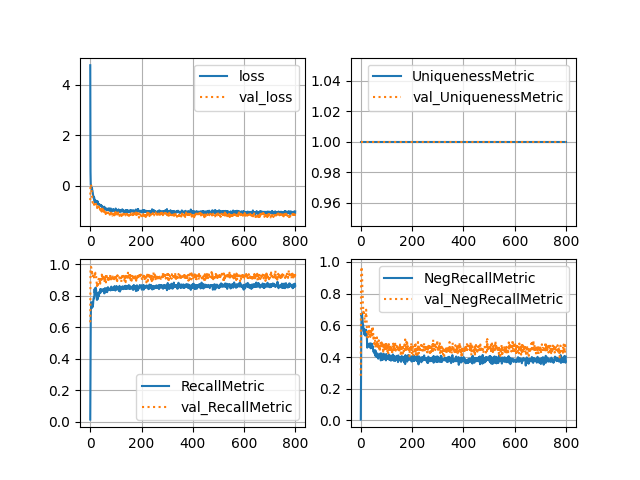

In [14]:
# Plot training history
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]
axes = fig.subplots(int(len(lines)/2), 2)
for i in range(len(lines)):
    label = lines[i]
    ax = axes.flatten()[i]
    val_label = 'val_' + label
    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
        ax.grid()
    ax.legend()